# Week 2: Model Selection & Curse of Dimensionality

Your task for today is to create the __most generalizable__ model from datasets of different sizes. 

We will use 3 partitions of the [Titanic](https://www.kaggle.com/c/titanic) dataset of size 100, 400, and 891. This is a fairly straightforward binary classification task with the goal of predicting _who survived_0 when the Titanic sunk. 

The dataset has the following columns: 

| Variable | Definition                                 | Key                                            |   |   |
|:----------|:--------------------------------------------|:------------------------------------------------|---|---|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |   |   |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |   |   |
| Sex      | Sex                                        |                                                |   |   |
| Age      | Age in years                               |                                                |   |   |
| Sibsp    | # of siblings / spouses aboard the Titanic |                                                |   |   |
| Parch    | # of parents / children aboard the Titanic |                                                |   |   |
| Ticket   | Ticket number                              |                                                |   |   |
| Fare     | Passenger fare                             |                                                |   |   |
| Cabin    | Cabin number                               |                                                |   |   |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |   |   |




There are some pecularities in the data: some columns contain missing values, some are redundant, and some might only be useful with feature engineering.

__Exercise__:

The following shows a simple example of fitting a logistic regression model to the data with 400 training examples.

- Run the code and discuss ways to improve it

In [90]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [91]:
data_folder = "titanic" # set to the name of the folder where you keep the data
test = pd.read_csv(os.path.join(data_folder, "test.csv"))
#train = pd.read_csv(os.path.join(data_folder, "train_100.csv"))
train = pd.read_csv(os.path.join(data_folder, "train_400.csv"))
#train = pd.read_csv(os.path.join(data_folder, "train_full.csv"))


In [92]:
# And the test set
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

In [93]:
# Okay, lots of missing age values. Filling them with the mean value of the column
train["Age"] = train["Age"].fillna(train["Age"].mean())
test["Age"] = test["Age"].fillna(train["Age"].mean())

# 1 missing Fare in test, filling with the mean
test["Fare"] = test["Fare"].fillna(train["Fare"].mean())

# Mean imputation is very naive - can you think of better ways to impute the missing values?

In [94]:
# Let's see if it worked
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          309
Embarked         1
dtype: int64

# Feature Engineering:
## Cabin_binary:
Binary, records whether logs had an NA or not 

## Family_size:
Integer, sums the number of siblings and children of the passenger

## Age_bin:
Bins the different age groups into children ($age \leq 14$), adult ($15 \leq age \leq 39$) and old ($40 \leq age$ )

In [95]:
def binarize_cabin(df):
   cabins = df["Cabin"].values
   df["Cabin_binary"] = [1 if isinstance(cabin, str) else 0 for cabin in cabins]
   return df

def get_family_size(df):
   siblings, children = df["SibSp"].values, df["Parch"].values
   df["Family_size"] = [siblings[i] + children[i] for i in range(len(siblings))]
   return df

def bin_age(age):
   if age < 15:
      return "child"
   elif age < 40:
      return "adult"
   else:
      return "old"   

train, test = binarize_cabin(train), binarize_cabin(test)
train, test = get_family_size(train), get_family_size(test)

train["Age_bin"] = train["Age"].apply(lambda x: bin_age(x))
test["Age_bin"] = test["Age"].apply(lambda x: bin_age(x))

# Constructing dummy variables (splitting and binarizing)

In [96]:
# sklearn does not like columns with  categorical values
# make them binary dummy variables instead
train = pd.get_dummies(train, columns=["Pclass", "Embarked", "Sex", "Age_bin"])
test =  pd.get_dummies(test, columns=["Pclass", "Embarked", "Sex", "Age_bin"])

In [97]:
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Cabin_binary,...,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Age_bin_adult,Age_bin_child,Age_bin_old
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,...,0,1,0,0,1,0,1,1,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,...,0,0,1,0,0,1,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,...,0,1,0,0,1,1,0,1,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,...,0,0,0,0,1,1,0,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,...,0,1,0,0,1,0,1,1,0,0


# Drop uninformative columns

In [98]:
# PassengerId, Name, and Ticket are practically unique for each individual and thus unusable for predictions
# Cabin has a lot of missing values and a lot of unique values. Dropping the columns

uninformative_cols = ["PassengerId", "Name", "Ticket", "Cabin", "Parch", "SibSp", "Embarked_C", "Embarked_Q", "Embarked_S", "Age", "Fare"] #
train = train.drop(columns=uninformative_cols)
test = test.drop(columns=uninformative_cols)

# Could Cabin be made informative with some feature engineering?

# Readying the data

In [99]:
# Make subset of training data containing everything except the label
X = train.loc[:, train.columns != "Survived"]
# Make subset containing only the label
Y = train["Survived"]
X_test = test.loc[:, train.columns != "Survived"]
Y_test = test["Survived"]

.. That was not very impressive. Our expectation of performance was horribly miscalibrated, as we fared much worse on the test set than on our training set. Our model also seems to overpredict survival on the test data.

Now it's your turn to do better

__Exercises__:

Discuss:

- How can you get a better estimate of the out-of-sample performance?
- How can you reduce overfitting to the training data?
- Do you need different strategies for model creation for the different sizes of dataset?
    - If so, what would you do differently?

Code:

- For each partition (i.e. each dataset) create at least 3 different models that you expect to generalize well. Evaluate them on the training sample using some form of model selection (cross-validated performance, held-out data, information criteria etc.) and choose one to test on the testing set. Your goal is to create the best performing, most well-calibrated model, ie. training performance should be close to testing performance (and performance should of course be high!). 
- Test how good performance you can get on the small datasets with clever optimization and regularization.

For next time:

- In your study groups, prepare a 3-5 min presentation on something interesting about your solution: Did you create some cool functions for preprocessing, test an exciting new type of model, set everything up to be run from the command line, or perhaps you're just really excited about the performance of your model. No need for slideshows, but feel free to show code.

---

Tips to get started:
- Visualization can often be a good way to get started: how is the distribution of the variables? are any of them highly correlated?
- Instead of training and testing on the whole training data, implement a form of cross-validation ([sk-learn makes it easy](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics))
- Remember ridge regularization from last week? [Try it](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)
- Check out a list of models in sk-learn [here](https://scikit-learn.org/stable/supervised_learning.html)
- Lost or out of ideas? Take some inspiration from entries in the [original Kaggle challenge](https://www.kaggle.com/c/titanic/code)

Things to try:
- You might be able to get more information out of the predictors if you do some feature engineering. Perhaps add a column indicating whether the person had a cabin or not, or one calculating the family size?
- Calculating information criteriais not entirely straight-forward in sk-learn. [This tutorial](https://machinelearningmastery.com/probabilistic-model-selection-measures/) might help
- The outcome (survival) is not completely balanced. Over-/under-sampling might help
- Ensemble models often generalize better than single models. Try one of the methods [here](https://scikit-learn.org/stable/modules/ensemble.html)
- Don't feel restricted to sk-learn. Feel to make a Bayesian model in [PyMC3](https://github.com/pymc-devs/pymc3) or any other framework you want
- High-performance interpretable models are all the rage right now. [Try one of them!](https://github.com/interpretml/interpret) 


# Main Function


In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
import re

def get_cross(model_inst, X, Y, cv = 8, scoring = "f1_weighted"):
    model = model_inst
    model.fit(X, Y)
    yhat = model.predict(X)
    acc_train = accuracy_score(Y, yhat)
    yhat_test = model.predict(X_test)
    acc_test = accuracy_score(Y_test, yhat_test)
    scores = cross_val_score(model_inst, X, Y, cv=8, scoring = "f1_weighted")
    print(f"mean = {np.mean(scores)}, sd = {np.std(scores)}")
    return {"acc_train": acc_train, "acc_test": acc_test, "mean_cross": np.mean(scores), "std_cross": np.std(scores), "conf_mat": confusion_matrix(Y, yhat)}

### NESTED DICT APPROACH:

list_of_models = [LogisticRegression(), RandomForestClassifier(n_estimators = 60, n_jobs = -1, random_state = 42), MLPClassifier(solver = "adam", alpha = 0.001, hidden_layer_sizes=(1000,100)), RidgeClassifier(), AdaBoostClassifier()]

model_performance = {re.split("\(", str(i))[0]: get_cross(i, X, Y) for i in list_of_models}

model_performance

mean = 0.8206382543085313, sd = 0.04115697646459375
mean = 0.8262494703484051, sd = 0.05232619351341493
mean = 0.8262784405867383, sd = 0.0606673896198164
mean = 0.8140810780506366, sd = 0.05005694365385111
mean = 0.822712625941947, sd = 0.062425634235132636


{'LogisticRegression': {'acc_train': 0.825,
  'acc_test': 0.9832535885167464,
  'mean_cross': 0.8206382543085313,
  'std_cross': 0.04115697646459375,
  'conf_mat': array([[215,  28],
         [ 42, 115]], dtype=int64)},
 'RandomForestClassifier': {'acc_train': 0.87,
  'acc_test': 0.9449760765550239,
  'mean_cross': 0.8262494703484051,
  'std_cross': 0.05232619351341493,
  'conf_mat': array([[223,  20],
         [ 32, 125]], dtype=int64)},
 'MLPClassifier': {'acc_train': 0.8675,
  'acc_test': 0.9449760765550239,
  'mean_cross': 0.8262784405867383,
  'std_cross': 0.0606673896198164,
  'conf_mat': array([[221,  22],
         [ 31, 126]], dtype=int64)},
 'RidgeClassifier': {'acc_train': 0.82,
  'acc_test': 0.9952153110047847,
  'mean_cross': 0.8140810780506366,
  'std_cross': 0.05005694365385111,
  'conf_mat': array([[211,  32],
         [ 40, 117]], dtype=int64)},
 'AdaBoostClassifier': {'acc_train': 0.84,
  'acc_test': 0.9760765550239234,
  'mean_cross': 0.822712625941947,
  'std_cross':

# Indexing the dictionary

In [120]:
model_performance["RidgeClassifier"]["acc_train"]

0.82

## But obviously, you can't interpret these and look under the hood...
# OR CAN YOU?!
Introducing glassbox modeling

In [75]:
from interpret.glassbox import LogisticRegression, ExplainableBoostingClassifier
#from interpret.greybox import DecisionTreeClassifier
from interpret import show

ebm_log = LogisticRegression()
ebm_log.fit(X, Y)

emb_exp = ExplainableBoostingClassifier()
emb_exp.fit(X,Y)

ebm_global = emb_exp.explain_global()
show(ebm_global)

ebm_global = ebm_log.explain_global()
show(ebm_global)

# or substitute with LogisticRegression, DecisionTreeClassifier, RuleListClassifier, ...
# EBM supports pandas dataframes, numpy arrays, and handles "string" data natively.

<!-- http://127.0.0.1:7001/1881228372240/ -->

<!-- http://127.0.0.1:7001/1881272768016/ -->

In [76]:
y_hat_test = emb_exp.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, y_hat_test)}")
#confusion_matrix(Y_test, y_hat_test)


Accuracy on test data: 0.9593301435406698


In [77]:
confusion_matrix(Y_test, y_hat_test)

array([[256,  10],
       [  7, 145]], dtype=int64)

# What would Bayes have done?

In [16]:
from sklearn.preprocessing import MinMaxScaler
import arviz as az
import pymc3 as pm

In [17]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [18]:
columns = train.columns
columns

Index(['Survived', 'Cabin_binary', 'Family_size', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Age_bin_adult', 'Age_bin_child',
       'Age_bin_old'],
      dtype='object')

In [31]:
# theano tensor import. 
import theano.tensor as T

# logistic 
def logistic(l):
    return 1 / (1 + T.exp(-l))

# make the model
basic_model = pm.Model()

with basic_model:
    
    #data = pm.Data('data', x)
    
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu = 0, sigma = 1)
    beta = pm.Normal("beta", mu = 0, sigma = 1, shape = 9) # shape = 3 since we have 3 predictors. 
    
    # Expected value of outcome
    mu = alpha + beta[0] * train[columns[1]].values + beta[1] * train[columns[2]].values + beta[2] * train[columns[3]].values + beta[3] * train[columns[4]].values + beta[4] * train[columns[5]].values + beta[5] * train[columns[6]].values + beta[5] * train[columns[6]].values + beta[6] * train[columns[7]].values + beta[7] * train[columns[9]].values + beta[8] * train[columns[10]].values

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(mu), observed = train[columns[0]].values)

In [32]:
map_estimate = pm.find_MAP(model = basic_model)
map_estimate

In [33]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [beta]
>Slice: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 121 seconds.
The number of effective samples is smaller than 10% for some parameters.


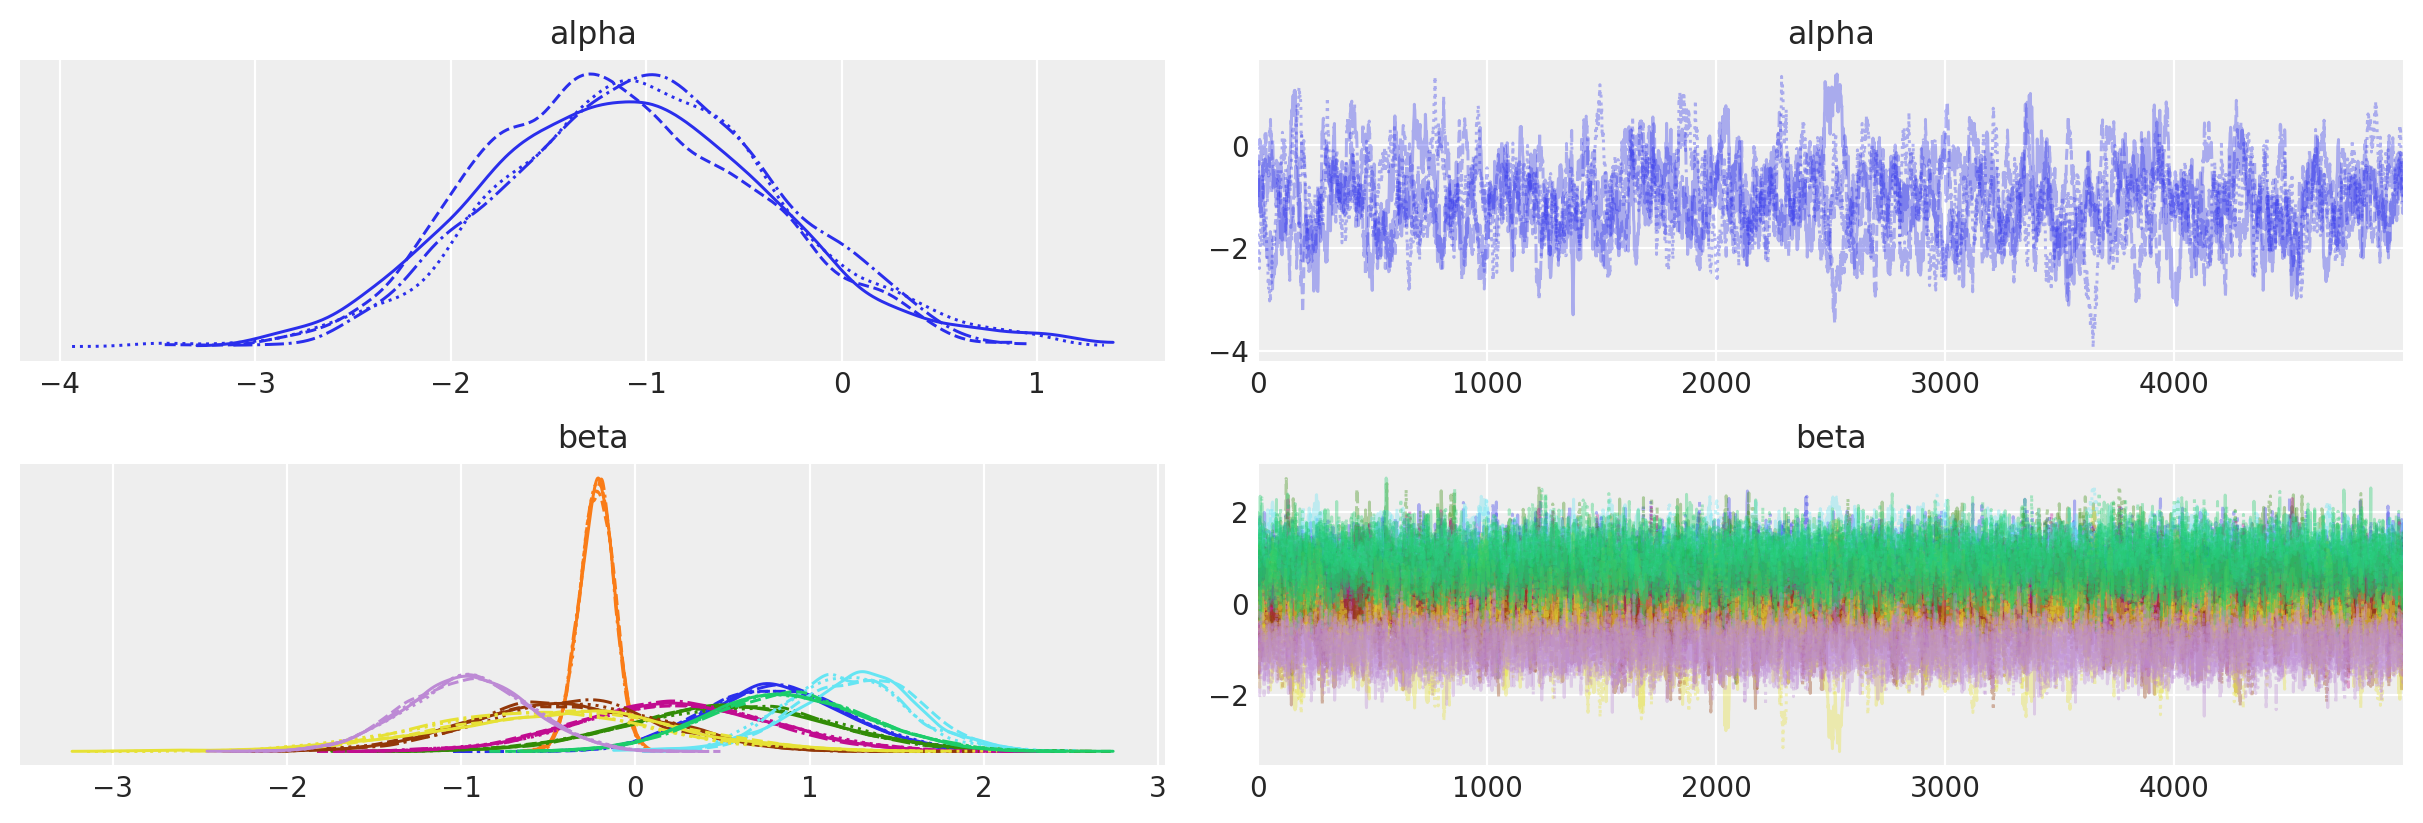

In [34]:
with basic_model:
    az.plot_trace(trace);

In [35]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.07,0.72,-2.40,0.29,0.04,0.03,414.88,414.88,415.41,926.88,1.01
beta[0],0.80,0.42,0.04,1.60,0.01,0.00,4666.02,4666.02,4673.09,7691.37,1.00
beta[1],-0.22,0.10,-0.41,-0.04,0.00,0.00,7294.67,7294.67,7297.21,10385.68,1.00
beta[2],0.55,0.59,-0.57,1.68,0.02,0.01,859.82,859.82,860.70,1915.71,1.00
beta[3],0.23,0.56,-0.77,1.34,0.02,0.01,759.05,759.05,759.69,1805.77,1.00
beta[4],-0.38,0.55,-1.38,0.69,0.02,0.01,681.50,681.50,682.54,1387.41,1.00
beta[5],1.24,0.36,0.55,1.90,0.02,0.01,465.96,462.35,465.29,968.74,1.01
beta[6],-0.49,0.69,-1.74,0.89,0.03,0.02,458.43,458.43,457.82,946.38,1.01
beta[7],0.87,0.46,0.04,1.77,0.00,0.00,8623.74,8365.84,8645.62,10429.48,1.00
beta[8],-0.97,0.36,-1.62,-0.28,0.00,0.00,9719.90,9719.90,9696.33,10982.02,1.00
